# Packages Import

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [6]:
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("pastel")
np.random.seed(42)

# Data Import

In [7]:
customers = pd.read_csv("data/customers.csv")

In [8]:
customers.head()

Unnamed: 0                customer_unique_id  order_frequency  total_price  \
0           0  0000366f3b9a7992bf8c76cfdf3221e2                1       141.90   
1           1  0000b849f77a49e4a4ce2b2a4ca5be3f                1        27.19   
2           2  0000f46a3911fa3c0805444483337064                1        86.22   
3           3  0000f6ccb0745a6a4b88665a16c9f078                1        43.62   
4           4  0004aac84e0df4da2b147fca70cf8255                1       196.89   

   mean_item_count  mean_category_count  review_score  comment  \
0              1.0                  1.0           5.0      1.0   
1              1.0                  1.0           4.0      0.0   
2              1.0                  1.0           3.0      0.0   
3              1.0                  1.0           4.0      1.0   
4              1.0                  1.0           5.0      0.0   

   payment_installments  payment_type_count  late_delivery  recency  
0                   8.0                 1.0              0      111  
1                   1.0                 1.0              0      114  
2                   8.0                 1.0              0      536  
3                   4.0                 1.0              0      320  
4                   6.0                 1.0              0      287

In [9]:
customers.drop(columns=["Unnamed: 0", "customer_unique_id"], inplace=True)

# Analysis

## Correlations

<Axes: >

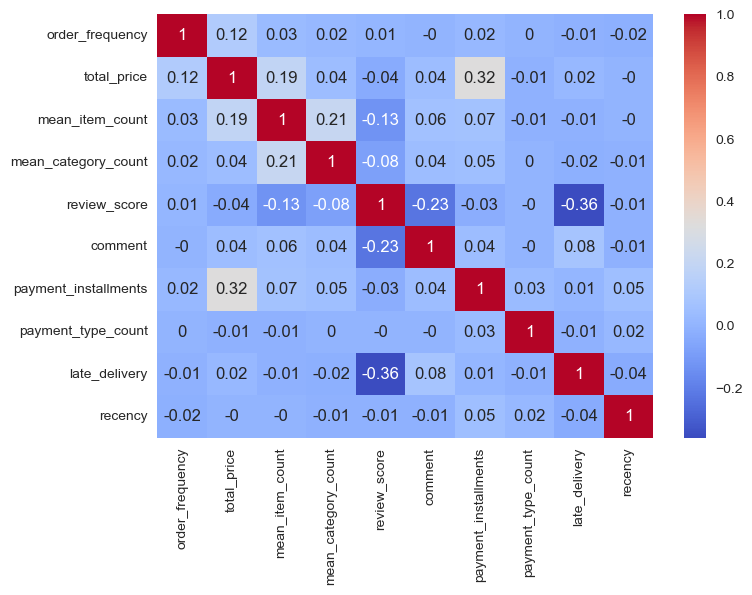

In [10]:
sns.heatmap(
    data=customers.corr(numeric_only=True).round(2),
    cmap="coolwarm",
    annot=True,
)

## Distributions

In [11]:
def kde_plots(df):
    columns = df.columns
    n_cols = 4
    n_rows = (len(columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, 4, figsize=(12, 8))
    for i, column in enumerate(columns):
        row_idx = i // n_cols
        col_idx = i % n_cols
        ax = axes[row_idx, col_idx]

        sns.kdeplot(df[column], ax=ax)

        ax.set_title(f"{column}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Density")

    if i + 1 < n_rows * n_cols:
        for j in range(i + 1, n_rows * n_cols):
            axes.flat[j].set_visible(False)

    fig.suptitle("Feature Distributions", fontsize=15)
    plt.tight_layout()
    plt.show()

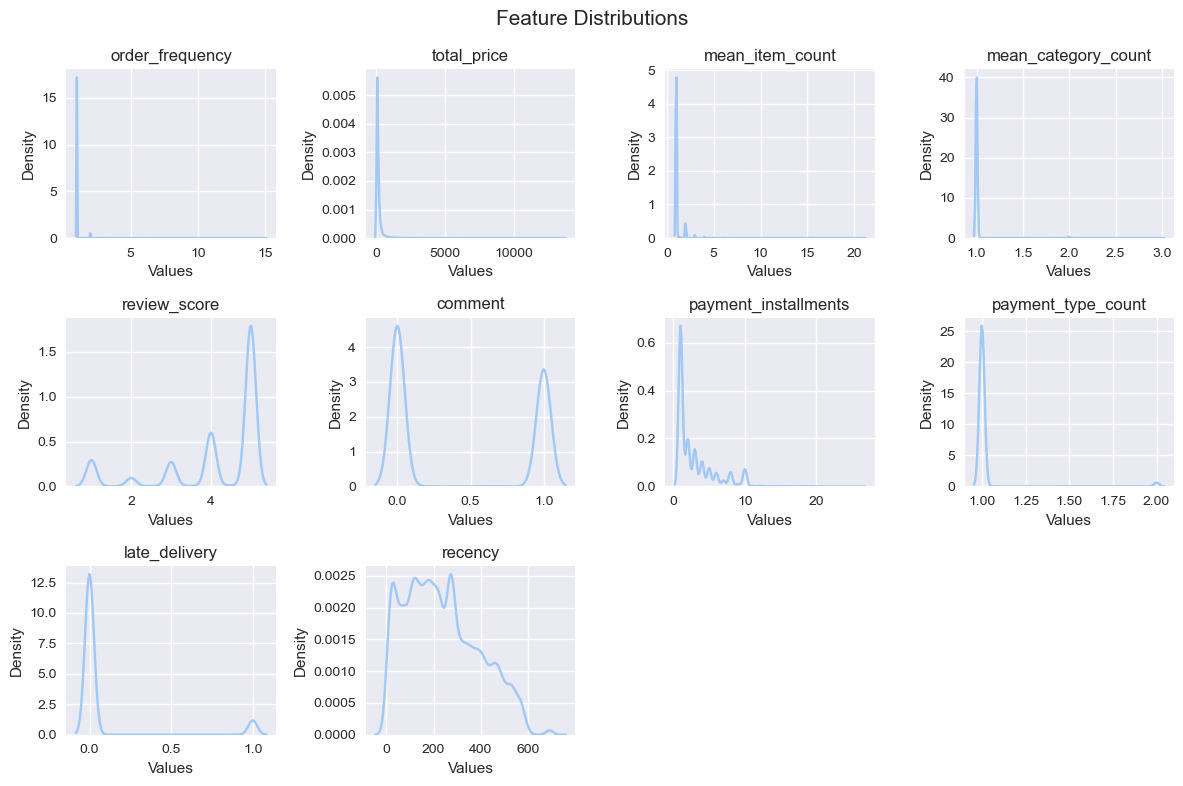

In [12]:
kde_plots(customers)

## PCA

### PCA on all features 

In [13]:
customers.columns

Index(['order_frequency', 'total_price', 'mean_item_count',
       'mean_category_count', 'review_score', 'comment',
       'payment_installments', 'payment_type_count', 'late_delivery',
       'recency'],
      dtype='object')

In [14]:
def fit_pca(data):
    feature_count = data.shape[1]
    pca = PCA(n_components=feature_count)
    pca.fit(data)
    return pca

In [15]:
def show_scree_plot(pca, feature_count):
    variance_ratio = (pca.explained_variance_ratio_ * 100).round(2)
    variance_ratio_cum = variance_ratio.cumsum().round()

    x_list = range(1, feature_count + 1)
    plt.figure(figsize=(8, 4))
    plt.bar(x_list, variance_ratio)
    for index, value in enumerate(variance_ratio):
        plt.text(index + 1, value, str(value), ha="center", va="bottom")
    plt.xticks(np.arange(0, feature_count + 1, 1))
    plt.plot(x_list, variance_ratio_cum, c="red", marker="o")
    plt.xlabel("Components")
    plt.ylabel("Variance ratio")
    plt.title("Scree plot")
    plt.show()

In [16]:
def scale_data(df):
    scaler = StandardScaler()
    return scaler.fit_transform(df)

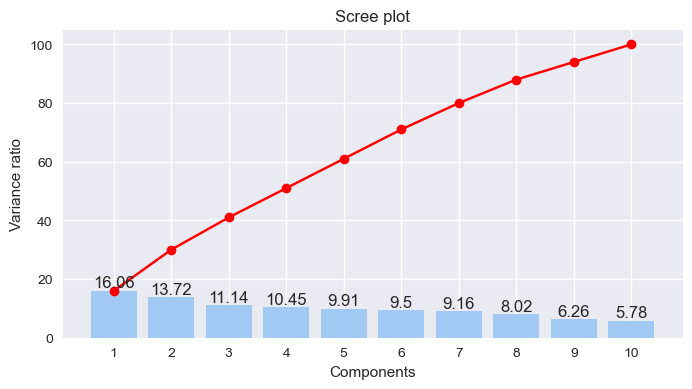

In [17]:
customers_scaled = scale_data(customers)
pca = fit_pca(customers_scaled)
show_scree_plot(pca, customers_scaled.shape[1])

Overall this PCA does not help to reduce the dimentionality of our dataset

In [18]:
def show_components_heatmap(pca, df, size=None):
    plt.figure(figsize=size or [10, 5])
    sns.heatmap(
        pd.DataFrame(pca.components_, columns=df.columns).round(2).T,
        cmap="coolwarm",
        annot=True,
    )
    plt.show()

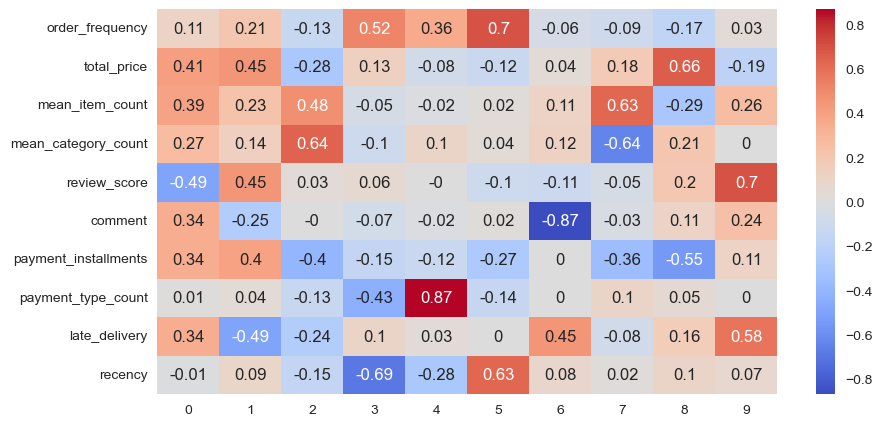

In [19]:
show_components_heatmap(pca, customers)

There are 6 features that contribute the most to the first component. 

Overall we see correlations between recency and frequency, late delivery, review score and comments, and between the price and the number of items, categories and payment installments.

In [20]:
def plot_correlation_circle(pca, features, components):
    fig = plt.figure(figsize=(12, 5))
    num = 0
    for x, y in components:
        num += 1
        ax = plt.subplot(1, 2, num)
        for i in range(0, pca.components_.shape[1]):
            ax.arrow(
                0,
                0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.04,
                head_length=0.04,
                width=0.02,
            )
            ax.text(
                pca.components_[x, i] + 0.02, pca.components_[y, i] + 0.02, features[i]
            )
        plt.plot([-1, 1], [0, 0], color="grey", ls="--")
        plt.plot([0, 0], [-1, 1], color="grey", ls="--")

        ax.set_xlabel(
            "F{} ({}%)".format(x + 1, round(100 * pca.explained_variance_ratio_[x], 1))
        )
        ax.set_ylabel(
            "F{} ({}%)".format(y + 1, round(100 * pca.explained_variance_ratio_[y], 1))
        )
        ax.set_title("Correlations (F{} et F{})".format(x + 1, y + 1))
        an = np.linspace(0, 2 * np.pi, 100)
        plt.plot(np.cos(an), np.sin(an))
        plt.axis("equal")
    plt.show()

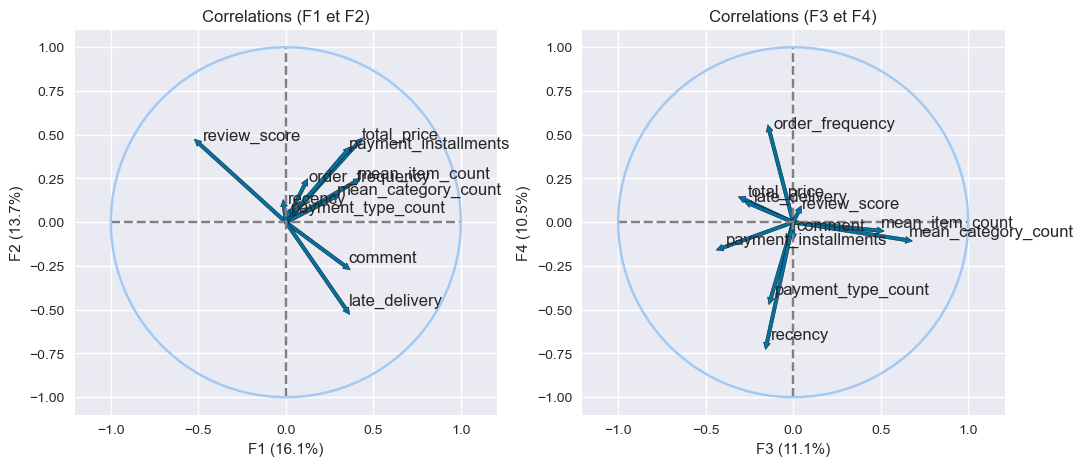

In [21]:
plot_correlation_circle(pca, customers.columns, [(0, 1), (2, 3)])

In [22]:
def display_factorial_planes(X_projected, components, pca):
    X_ = np.array(X_projected)
    fig = plt.figure(figsize=(12, 4))
    num = 0
    for x, y in components:
        num += 1
        ax = plt.subplot(1, 2, num)

        sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], ax=ax)

        v1 = str(round(100 * pca.explained_variance_ratio_[x])) + " %"
        v2 = str(round(100 * pca.explained_variance_ratio_[y])) + " %"

        ax.set_xlabel(f"F{x+1} {v1}")
        ax.set_ylabel(f"F{y+1} {v2}")

        x_max = np.abs(X_[:, x]).max() * 1.1
        y_max = np.abs(X_[:, y]).max() * 1.1

        ax.set_xlim(left=-x_max, right=x_max)
        ax.set_ylim(bottom=-y_max, top=y_max)

        plt.plot([-x_max, x_max], [0, 0], color="grey", alpha=0.8)
        plt.plot([0, 0], [-y_max, y_max], color="grey", alpha=0.8)
    plt.show()

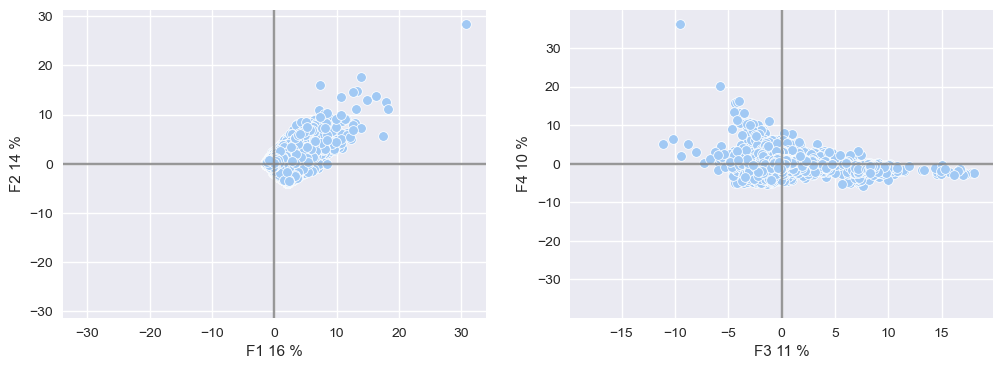

In [23]:
display_factorial_planes(pca.transform(customers_scaled), [(0, 1), (2, 3)], pca)

### PCA for RFM features

We'll perform the PCA on RFM features 

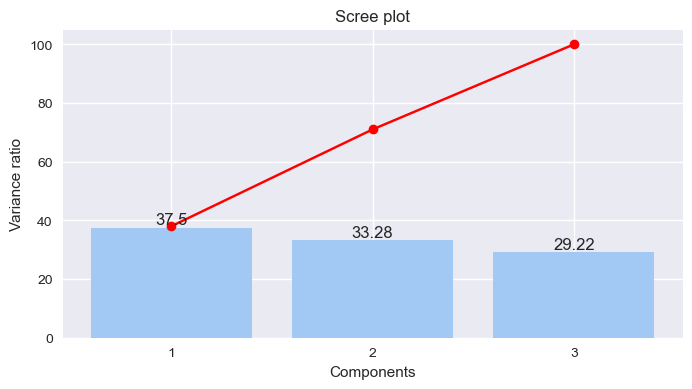

In [24]:
rfm_subset = customers[["order_frequency", "total_price", "recency"]]

rfm_scaled = scale_data(rfm_subset)
rfm_pca = fit_pca(rfm_scaled)
show_scree_plot(rfm_pca, 3)

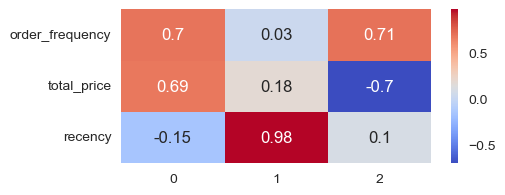

In [25]:
show_components_heatmap(rfm_pca, rfm_subset, [5, 2])

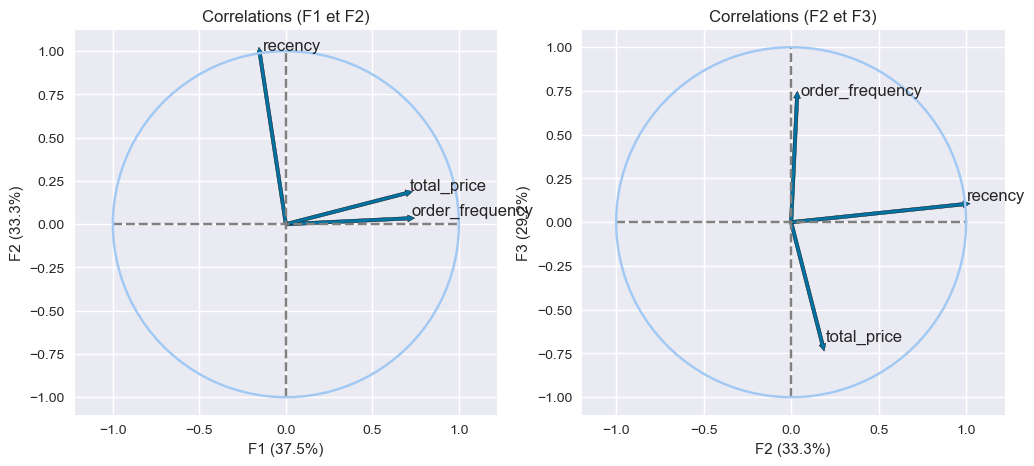

In [26]:
plot_correlation_circle(rfm_pca, rfm_subset.columns, [(0, 1), (1, 2)])

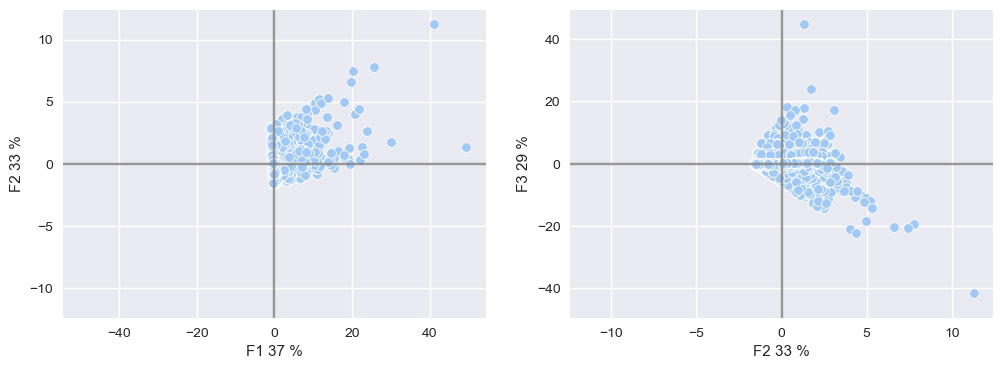

In [27]:
rfm_projected = rfm_pca.transform(rfm_scaled)
display_factorial_planes(rfm_projected, [(0, 1), (1, 2)], rfm_pca)

We'll use TSNE to see if we can capture other relationships in the data where the PCA cannot

In [28]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, n_jobs=-1, init="pca")
T = tsne.fit_transform(rfm_projected)
plt.figure(figsize=(8, 8))
sns.scatterplot(x=T[:, 0], y=T[:, 1])

KeyboardInterrupt: 

There are two main clusters, we'll see if we can visualize better relationships with more features

### PCA for RFM + Satisfaction 

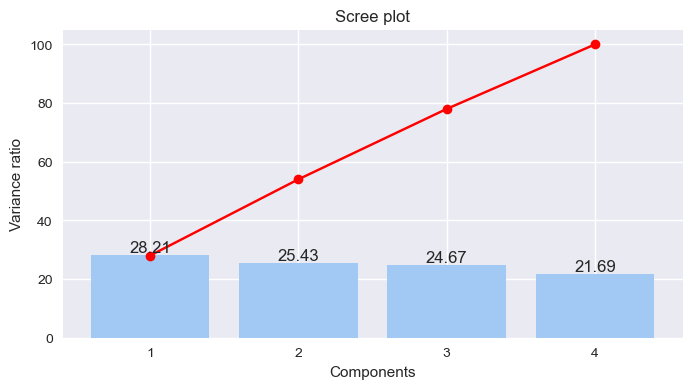

In [ ]:
rfms = customers[["order_frequency", "total_price", "recency", "review_score"]]

rfms_scaled = scale_data(rfms)
rfms_pca = fit_pca(rfms_scaled)
show_scree_plot(rfms_pca, 4)

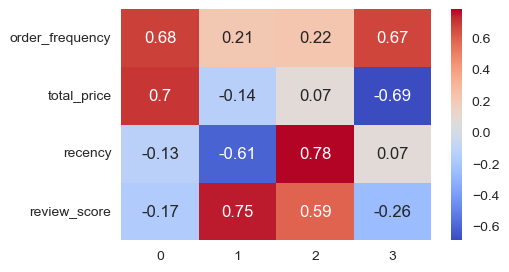

In [ ]:
show_components_heatmap(rfms_pca, rfms, [5, 3])

With this subset of features, the first component explains a significant percentage of the variance 

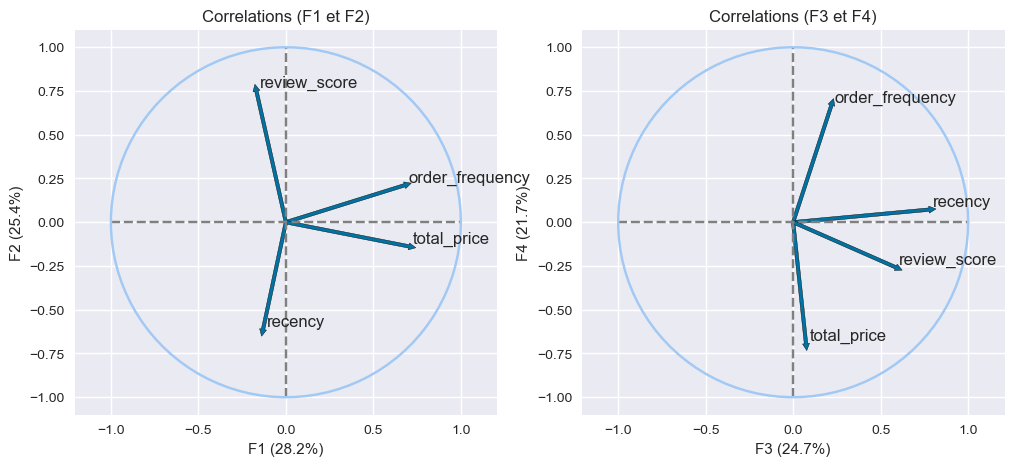

In [ ]:
plot_correlation_circle(rfms_pca, rfms.columns, [(0, 1), (2, 3)])

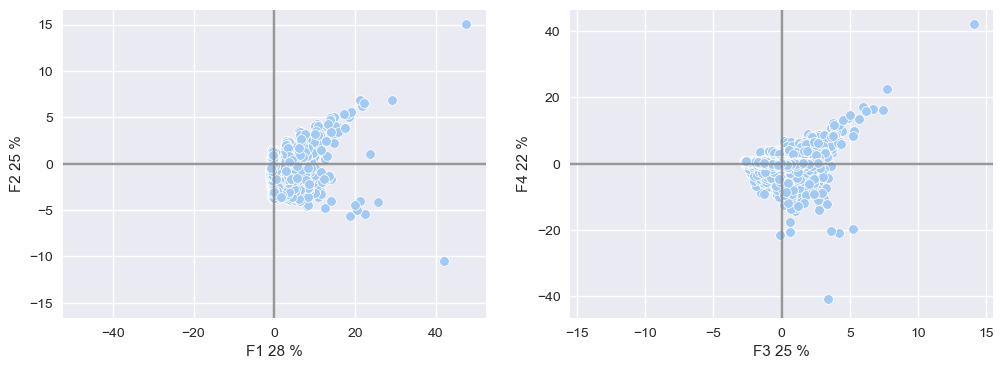

In [ ]:
rfms_projected_values = rfms_pca.transform(rfms_scaled)

display_factorial_planes(
    rfms_projected_values,
    [(0, 1), (2, 3)],
    rfms_pca,
)

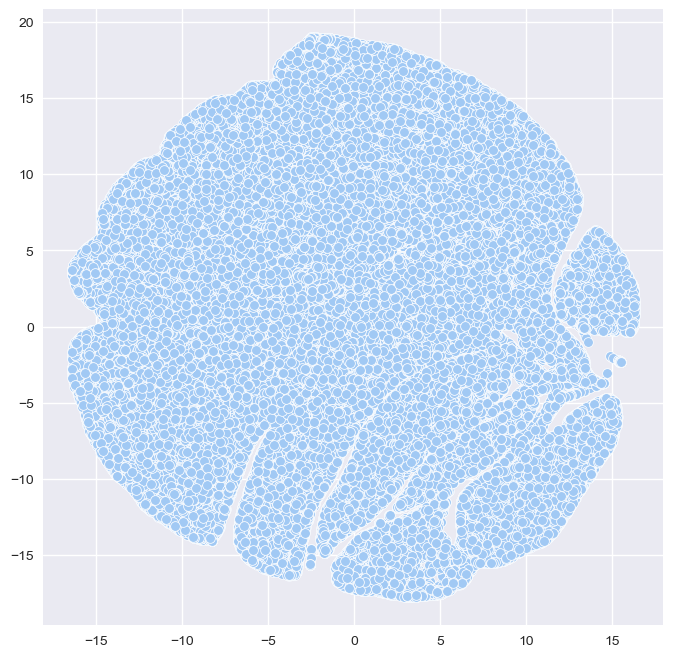

In [ ]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=300, n_jobs=-1, init="pca")
T = tsne.fit_transform(rfms_projected_values)
plt.figure(figsize=(8, 8))
sns.scatterplot(x=T[:, 0], y=T[:, 1])
plt.show()

# Clustering 

## RFM

### Finding optimal number of clusters

#### Elbow and Silhouette

In [32]:
def find_k(X):
    model = KMeans(n_init="auto")
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    visualgrid = [
        KElbowVisualizer(model, k=(2, 15), timings=False, ax=axes[0]),
        KElbowVisualizer(
            model, k=(2, 15), timings=False, metric="silhouette", ax=axes[1]
        ),
    ]

    for viz in visualgrid:
        viz.fit(X)
        viz.finalize()

    plt.tight_layout()
    plt.show()

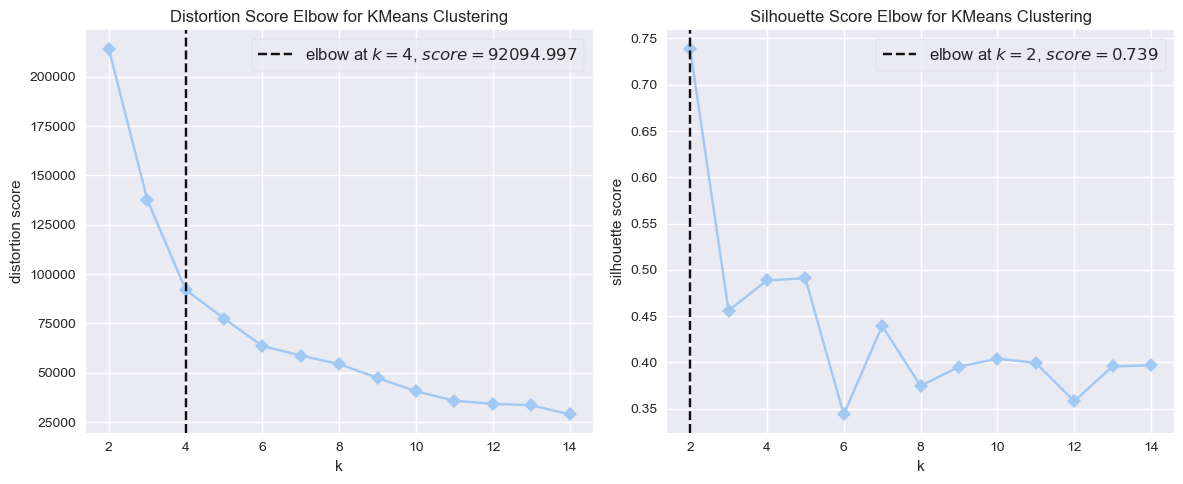

In [ ]:
find_k(rfm_scaled)

In [ ]:
def visualize_silhouette(X, clusters):
    num_plots = len(clusters)

    if num_plots == 1:
        model = KMeans(n_clusters=clusters[0], n_init="auto")
        visualizer = SilhouetteVisualizer(model)
        visualizer.fit(X=X)
        visualizer.poof()
        return

    num_rows = num_plots // 2 if num_plots % 2 == 0 else (num_plots // 2) + 1
    num_cols = 2 if num_plots > 1 else 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7))
    axes = axes.flatten()

    visualgrid = []

    for n_clusters, ax in zip(clusters, axes):
        model = KMeans(n_clusters=n_clusters, n_init="auto")
        visualgrid.append(SilhouetteVisualizer(model, ax=ax))

    for viz in visualgrid:
        viz.fit(X)
        viz.finalize()

    plt.tight_layout()
    plt.show()

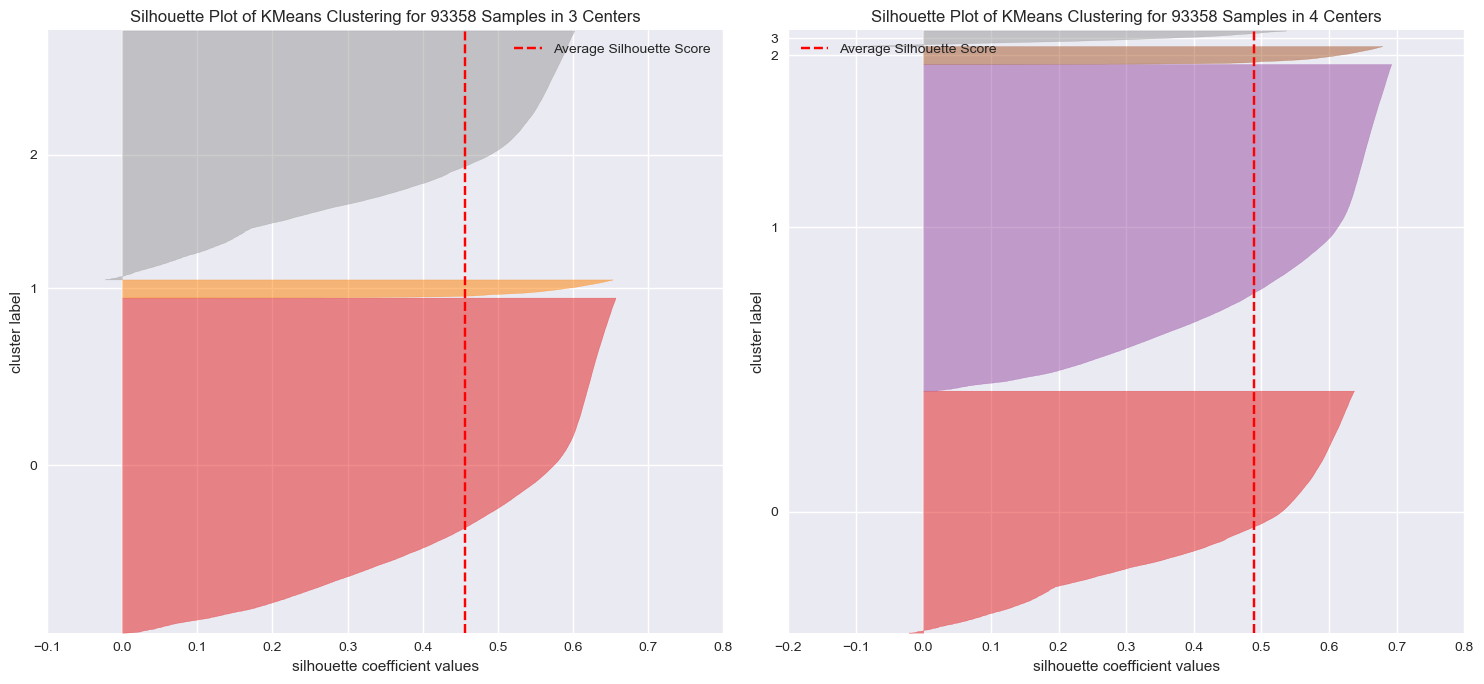

In [ ]:
visualize_silhouette(rfm_scaled, [3, 4])

### Dendrogram

In [78]:
rfm_scaled = pd.DataFrame(rfm_scaled, columns=rfm_subset.columns)
rfm_scaled

order_frequency  total_price   recency
0            -0.159829    -0.102824 -0.825357
1            -0.159829    -0.609738 -0.805697
2            -0.159829    -0.348879  1.959873
3            -0.159829    -0.537133  0.544321
4            -0.159829     0.140181  0.328056
...                ...          ...       ...
93353        -0.159829     8.406223  1.370059
93354        -0.159829    -0.356127  0.157665
93355        -0.159829    -0.232922  2.163031
93356        -0.159829    -0.139105 -0.779483
93357        -0.159829    -0.413663  1.612538

[93358 rows x 3 columns]

In [79]:
sampled_rfm = rfm_scaled.sample(frac=0.3, random_state=42)
sampled_rfm

order_frequency  total_price   recency
21568        -0.159829    -0.567757 -0.196223
52028        -0.159829    -0.452861 -0.969534
74245         4.622656    -0.251748  0.413251
45830        -0.159829     0.285128  0.740925
33285        -0.159829    -0.350780 -1.421724
...                ...          ...       ...
49902        -0.159829    -0.416624 -1.303761
20204        -0.159829    -0.486799  1.003064
54908        -0.159829     0.162542 -0.255204
42153        -0.159829    -0.491351  1.638752
22877        -0.159829    -0.338229 -1.329975

[28007 rows x 3 columns]

In [80]:
def plot_dendrogram(y):
    Z = linkage(y, method="ward")

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    _ = dendrogram(Z, p=15, truncate_mode="lastp", ax=ax)

    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Number of points in node")
    plt.ylabel("Distance.")
    plt.show()

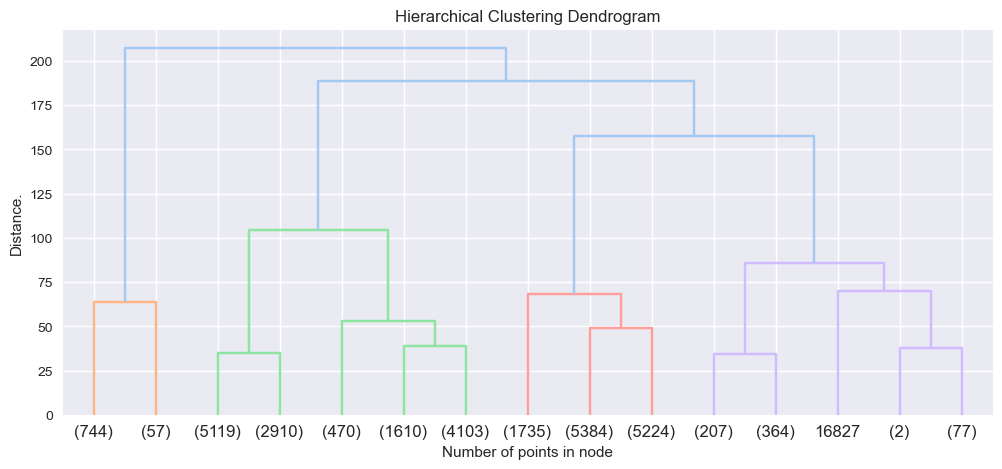

In [ ]:
plot_dendrogram(sampled_rfm)

The dendrogram requires time and is not suitable for big data sets. It therefore requires a sampling of the data which could generate unreliable clusters. 

This method will therefore not be selected as the primay clustering technique.

However, the dendrogram shows somewhat homogeneous clusters at the 150 marks, which can be used to confirm the choice of 4 clusters

### K-Means Algorithm

#### Visualizing clusters

In [35]:
def get_kmeans_clusters(X, k):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    return kmeans.fit_predict(X)

In [ ]:
rfm_scaled["cluster"] = get_kmeans_clusters(rfm_scaled, 4)

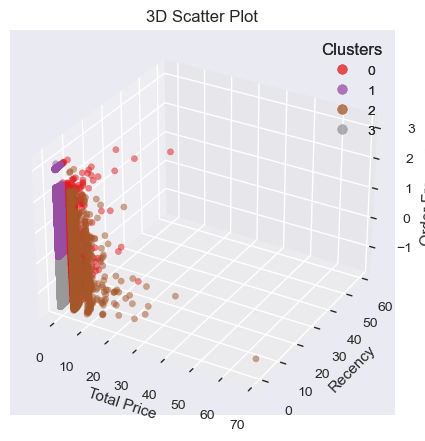

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    rfm_scaled["order_frequency"],
    rfm_scaled["total_price"],
    rfm_scaled["recency"],
    c=rfm_scaled["cluster"],
    cmap="Set1",
    alpha=0.5,
)

ax.set_xlabel("Total Price")
ax.set_ylabel("Recency")
ax.set_zlabel("Order Frequency")
ax.set_title("3D Scatter Plot")

legend1 = ax.legend(*scatter.legend_elements(),
                    title="Clusters", loc="upper right")
ax.add_artist(legend1)

plt.show()

In [ ]:
def plot_clusters(X, components, n_clusters):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes = axes.flatten()
    for component, ax in zip(components, axes):
        labels = get_kmeans_clusters(X[component], n_clusters)
        sns.scatterplot(
            x=X[component[0]],
            y=X[component[1]],
            hue=labels,
            palette="Set1",
            data=X[component],
            legend="full",
            alpha=0.5,
            ax=ax,
        ).set(title="Visualisation 2D")

    plt.tight_layout()
    plt.show()

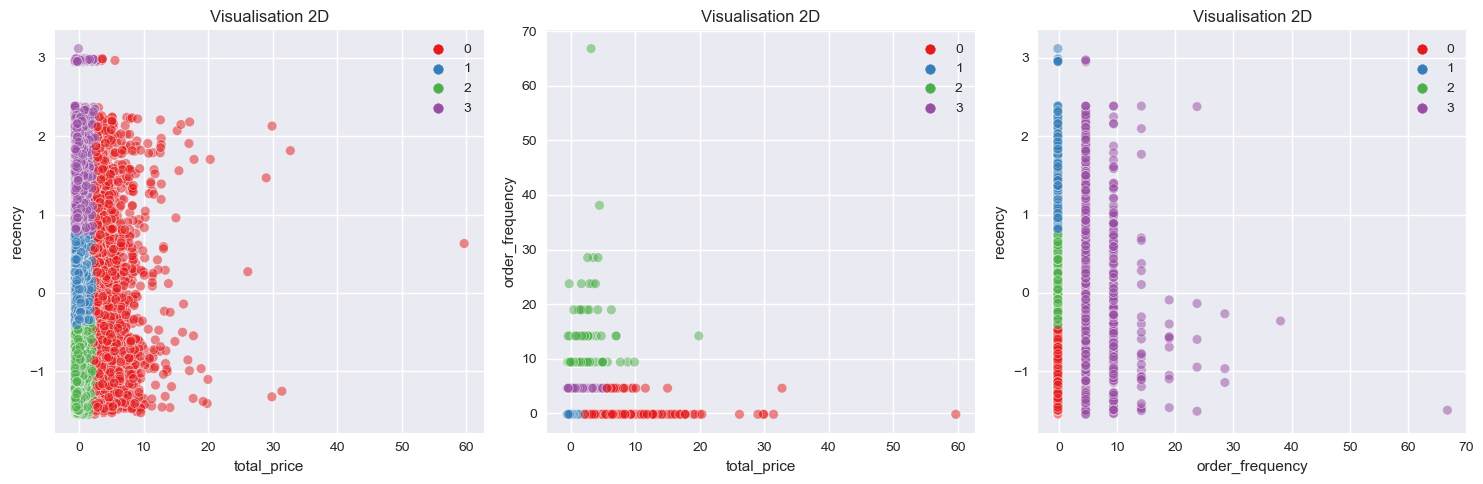

In [ ]:
plot_clusters(
    rfm_scaled,
    [
        ["total_price", "recency"],
        ["total_price", "order_frequency"],
        ["order_frequency", "recency"],
    ],
    4,
)

In [40]:
def plot_tsne(df, perplexity=30, iter=300):
    tsne = TSNE(n_components=2, perplexity=50, n_iter=300, n_jobs=-1)
    T = tsne.fit_transform(df.iloc[:, :-1])
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=T[:, 0], y=T[:, 1], hue=df["cluster"], palette="Set1")

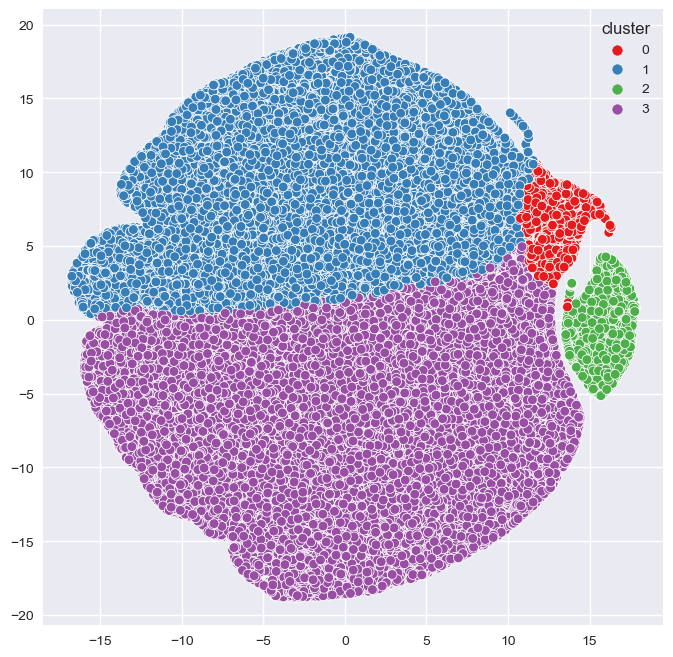

In [ ]:
plot_tsne(rfm_scaled)

In [ ]:
rfm_subset["cluster"] = rfm_scaled["cluster"]

/var/folders/ht/r34_b3vj4p7c88ck54235g_40000gn/T/ipykernel_70793/4203818548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_subset["cluster"] = rfm_scaled["cluster"]


### DBSCAN Algorithm

In [ ]:
def find_epsilon(X):
    silhouette_scores = []
    davies_bouldin_scores = []
    epsilon_values = np.linspace(0.1, 1.0, 10)

    for epsilon in epsilon_values:
        dbscan = DBSCAN(eps=epsilon, min_samples=50)
        labels = dbscan.fit_predict(X)

        if len(set(labels)) > 1:
            silhouette_scores.append(silhouette_score(X, labels))
            davies_bouldin_scores.append(davies_bouldin_score(X, labels))
        else:
            silhouette_scores.append(0)
            davies_bouldin_scores.append(np.inf)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(silhouette_scores, epsilon_values, marker="o")
    plt.ylabel("Epsilon (ε)")
    plt.xlabel("Silhouette Score")
    plt.title("Silhouette Score vs. Epsilon")

    plt.subplot(1, 2, 2)
    plt.plot(davies_bouldin_scores, epsilon_values, marker="o")
    plt.ylabel("Epsilon (ε)")
    plt.xlabel("Davies–Bouldin Index")
    plt.title("Davies–Bouldin Index vs. Epsilon")

    plt.tight_layout()
    plt.show()

    print(
        f"Best Epsilon (Silhouette Score): {epsilon_values[np.argmax(silhouette_scores)]}"
    )
    print(
        f"Best Epsilon (Davis-Bouldin Index): {epsilon_values[np.argmin(davies_bouldin_scores)]}"
    )

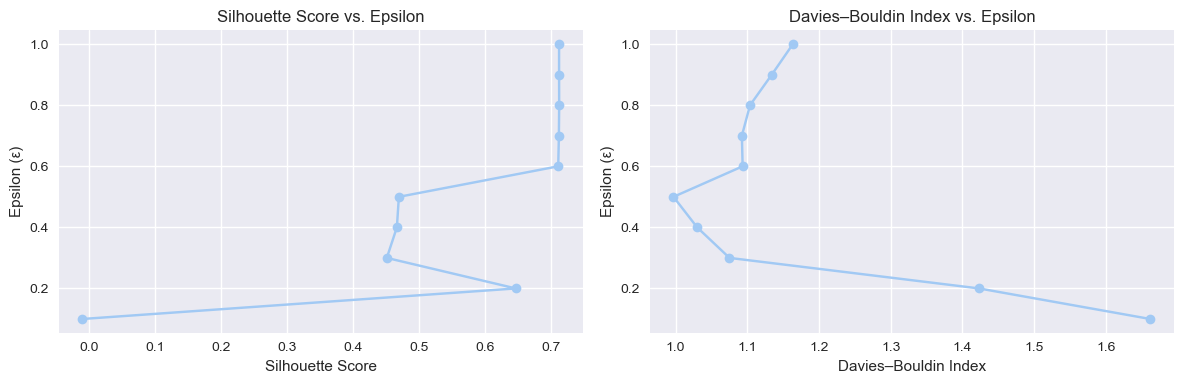

Best Epsilon (Silhouette Score): 0.8
Best Epsilon (Davis-Bouldin Index): 0.5


In [ ]:
find_epsilon(sampled_rfm)

In [ ]:
def get_dbscan_clusters(X, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    print(np.unique(labels))
    return labels

In [ ]:
sampled_rfm["cluster"] = get_dbscan_clusters(sampled_rfm, 0.8, 150)

[-1  0  1]


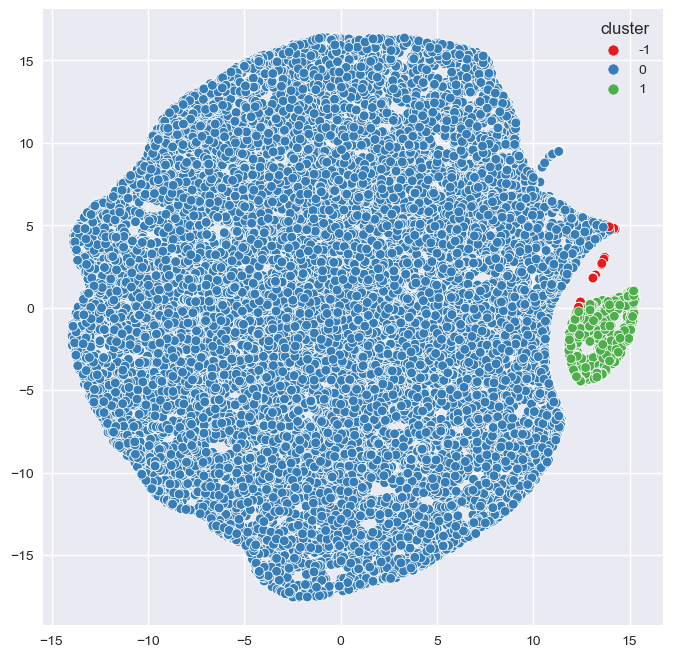

In [ ]:
plot_tsne(sampled_rfm)

DBSCAN is not as efficient as Kmeans in defining clear clusters. Most of them are not even visible and there are huge gaps in population sizes

### Interpreting results

In [ ]:
rfm_subset.describe()

order_frequency   total_price       recency       cluster
count     93358.000000  93358.000000  93358.000000  93358.000000
mean          1.033420    165.168210    236.941773      2.088327
std           0.209097    226.292101    152.591453      1.019974
min           1.000000      9.590000      0.000000      0.000000
25%           1.000000     63.010000    113.000000      1.000000
50%           1.000000    107.780000    218.000000      3.000000
75%           1.000000    182.510000    345.000000      3.000000
max          15.000000  13664.080000    713.000000      3.000000

In [ ]:
rfm_subset.groupby("cluster").agg(
    order_frequency=("order_frequency", "mean"),
    total_price=("total_price", "mean"),
    recency=("recency", "mean"),
    cluster_size=("cluster", "count"),
).round(2)

order_frequency  total_price  recency  cluster_size
cluster                                                     
0                   1.01      1159.99   238.38          2422
1                   1.00       133.49   386.37         37537
2                   2.11       289.62   219.44          2772
3                   1.00       134.25   127.04         50627

In [61]:
def plot_clusters_by_feature(X, plot="bar"):
    columns = X.iloc[:, :-1].columns
    num_plots = len(columns)
    num_rows = num_plots // 3 if num_plots % 3 == 0 else round(5 / 3) + 1
    num_cols = 3 if num_plots % 3 == 0 else 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))
    axes = axes.flatten()
    for column, ax in zip(columns, axes):
        sns.barplot(
            x="cluster",
            y=column,
            data=X,
            ax=ax,
        ).set(title=f"{column}") if plot == "bar" else sns.violinplot(
            x="cluster",
            y=column,
            data=X,
            ax=ax,
        ).set(
            title=f"{column}"
        )
    plt.tight_layout()
    plt.show()

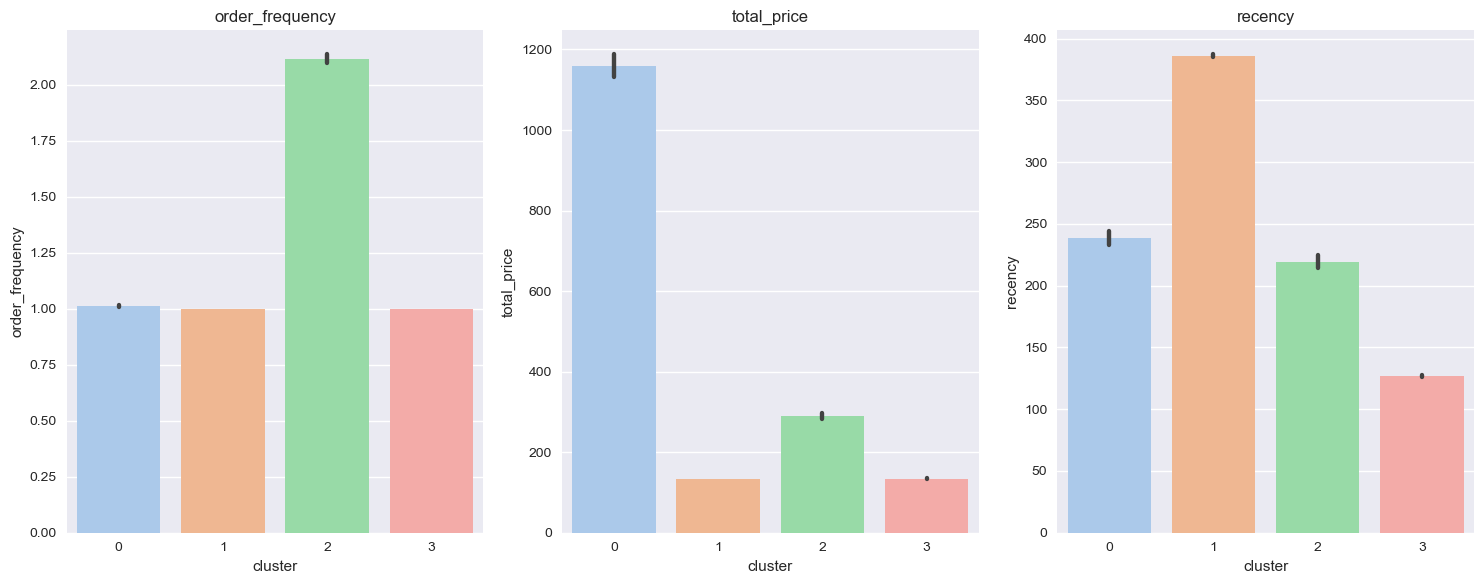

In [ ]:
plot_clusters_by_feature(rfm_subset)

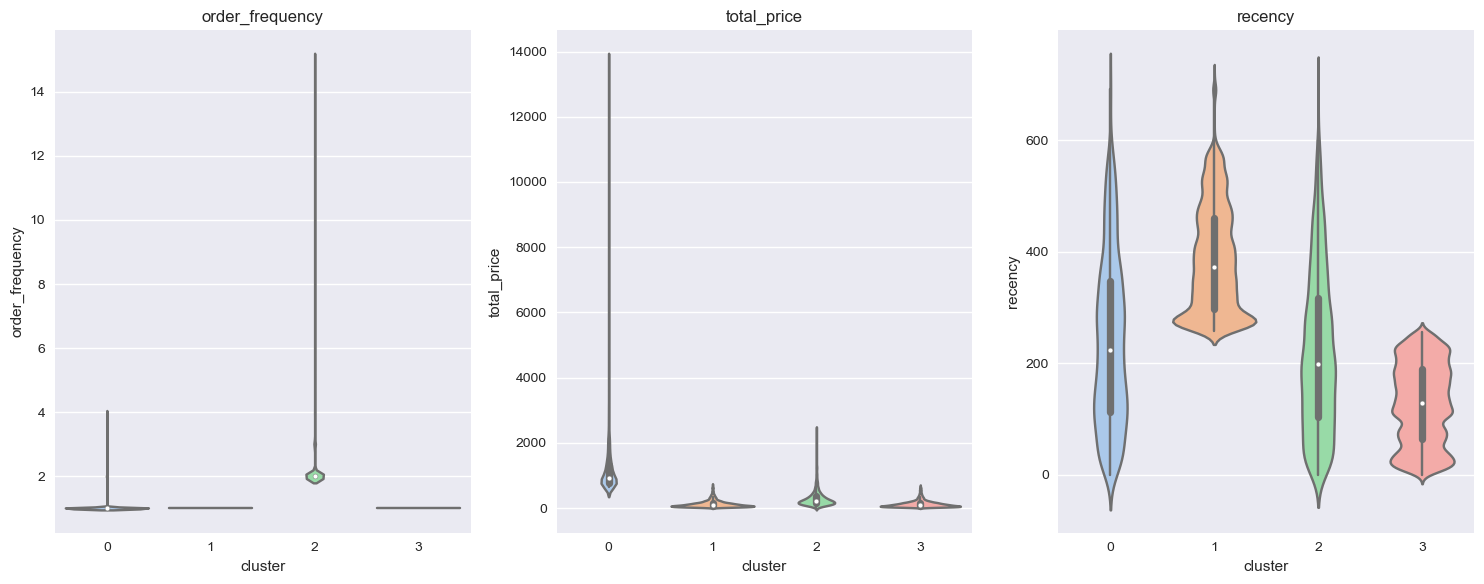

In [ ]:
plot_clusters_by_feature(rfm_subset, "violin")

Cluster 0 : More than 1 order, high spender, ordered within the year > Good customers

Cluster 1 : Single order, low spender, more than a year ago > Churners

Cluster 2 : Several orders, relatively high spenders, recent order > Loyal customers 

Cluster 3 : Single order, low spender, recent purchase > Testers 


We can already group customers by purchase habits, but we need another dimension to better differentiate and categorize some of them.

---

## RFM + Satisfaction

We'll check if we're able to discern customer habits better with a satisfaction metric 

### Finding optimal number of clusters

#### Elbow and silhouette

In [ ]:
rfms_scaled = scale_data(rfms)

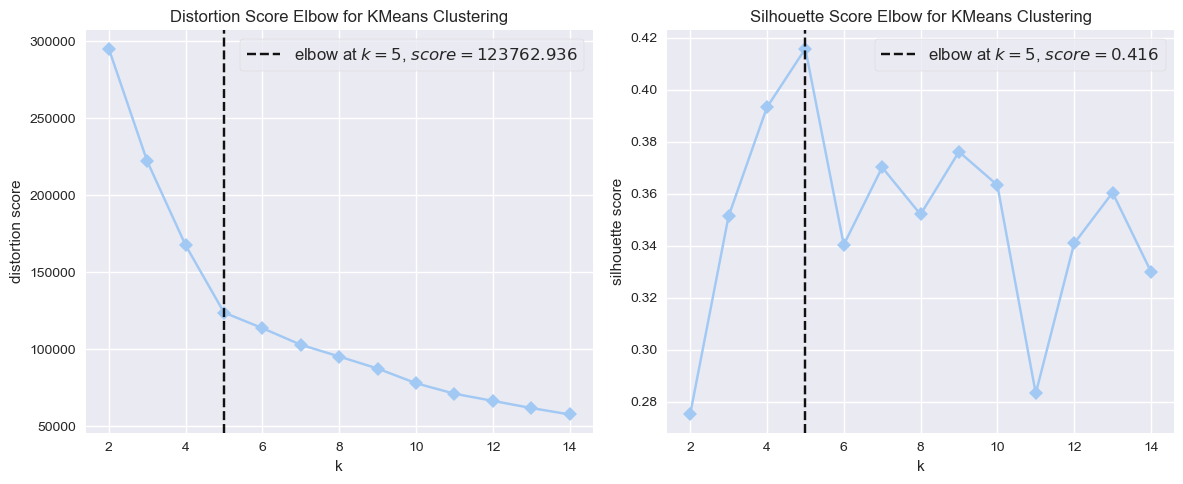

In [ ]:
find_k(rfms_scaled)

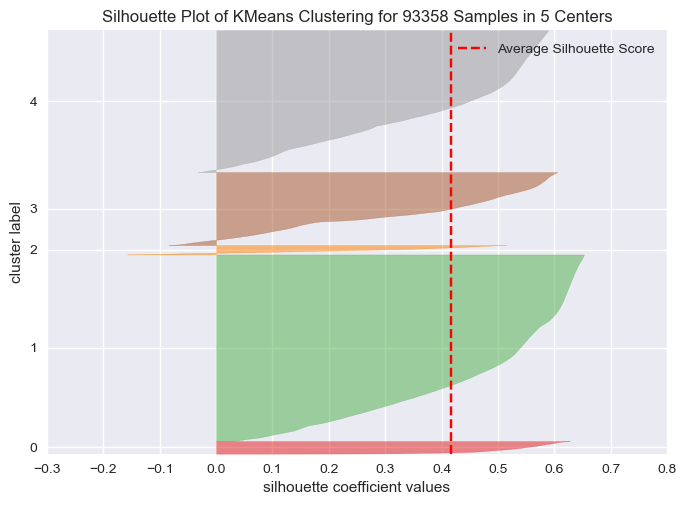

In [ ]:
visualize_silhouette(rfms_scaled, [5])

#### Dendogram

In [ ]:
rfms_scaled = pd.DataFrame(rfms_scaled, columns=rfms.columns)
rfms_scaled

order_frequency  total_price   recency  review_score
0            -0.159829    -0.102824 -0.825357      0.667574
1            -0.159829    -0.609738 -0.805697     -0.114184
2            -0.159829    -0.348879  1.959873     -0.895943
3            -0.159829    -0.537133  0.544321     -0.114184
4            -0.159829     0.140181  0.328056      0.667574
...                ...          ...       ...           ...
93353        -0.159829     8.406223  1.370059      0.667574
93354        -0.159829    -0.356127  0.157665     -0.114184
93355        -0.159829    -0.232922  2.163031      0.667574
93356        -0.159829    -0.139105 -0.779483      0.667574
93357        -0.159829    -0.413663  1.612538      0.667574

[93358 rows x 4 columns]

In [ ]:
sampled_rfms = rfms_scaled.sample(frac=0.3, random_state=42)
sampled_rfms

order_frequency  total_price   recency  review_score
21568        -0.159829    -0.567757 -0.196223      0.667574
52028        -0.159829    -0.452861 -0.969534     -0.114184
74245         4.622656    -0.251748  0.413251      0.667574
45830        -0.159829     0.285128  0.740925      0.667574
33285        -0.159829    -0.350780 -1.421724      0.667574
...                ...          ...       ...           ...
49902        -0.159829    -0.416624 -1.303761      0.667574
20204        -0.159829    -0.486799  1.003064      0.667574
54908        -0.159829     0.162542 -0.255204      0.667574
42153        -0.159829    -0.491351  1.638752     -2.459459
22877        -0.159829    -0.338229 -1.329975      0.667574

[28007 rows x 4 columns]

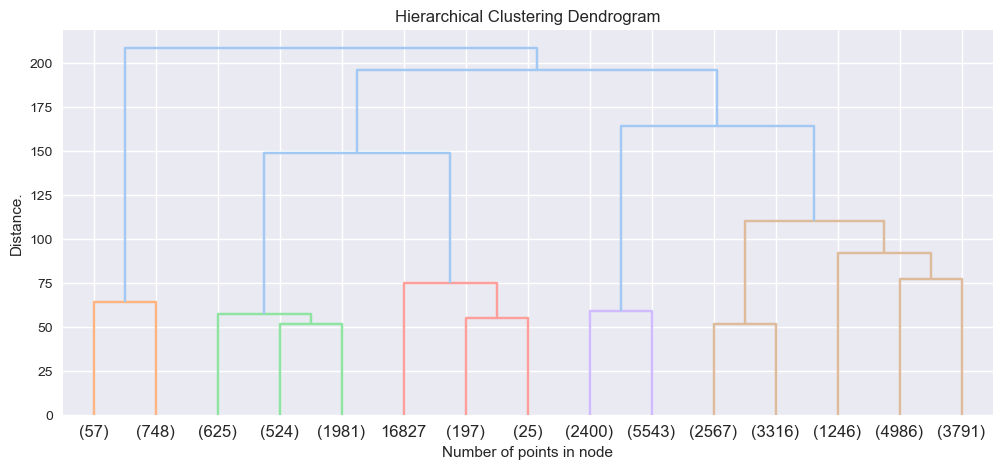

In [ ]:
plot_dendrogram(sampled_rfms)

The dendrogram displays 5 clusters at 125, however the cluster sizes are very unequal. 

### K-Means Algorithm

#### Visualizing clusters using ACP

In [ ]:
rfms_scaled_pca = pd.DataFrame(index=rfms_scaled.index)
rfms_scaled_pca["F1"] = rfms_projected_values[:, 0]
rfms_scaled_pca["F2"] = rfms_projected_values[:, 1]
rfms_scaled_pca["F3"] = rfms_projected_values[:, 2]

In [ ]:
rfms_scaled_pca

F1        F2        F3
0     -0.185427  0.985927 -0.291935
1     -0.412776  0.458217 -0.772343
2     -0.458630 -1.856803  0.935840
3     -0.537897 -0.378379  0.281258
4     -0.165084  0.246157  0.621534
...         ...       ...       ...
93353  5.510799 -1.534074  2.038309
93354 -0.360175 -0.166658 -0.005666
93355 -0.666868 -0.825769  2.018930
93356 -0.216922  0.962854 -0.258981
93357 -0.722110 -0.463748  1.578196

[93358 rows x 3 columns]

In [ ]:
rfms_scaled_pca["cluster"] = get_kmeans_clusters(rfms_scaled_pca, 6)

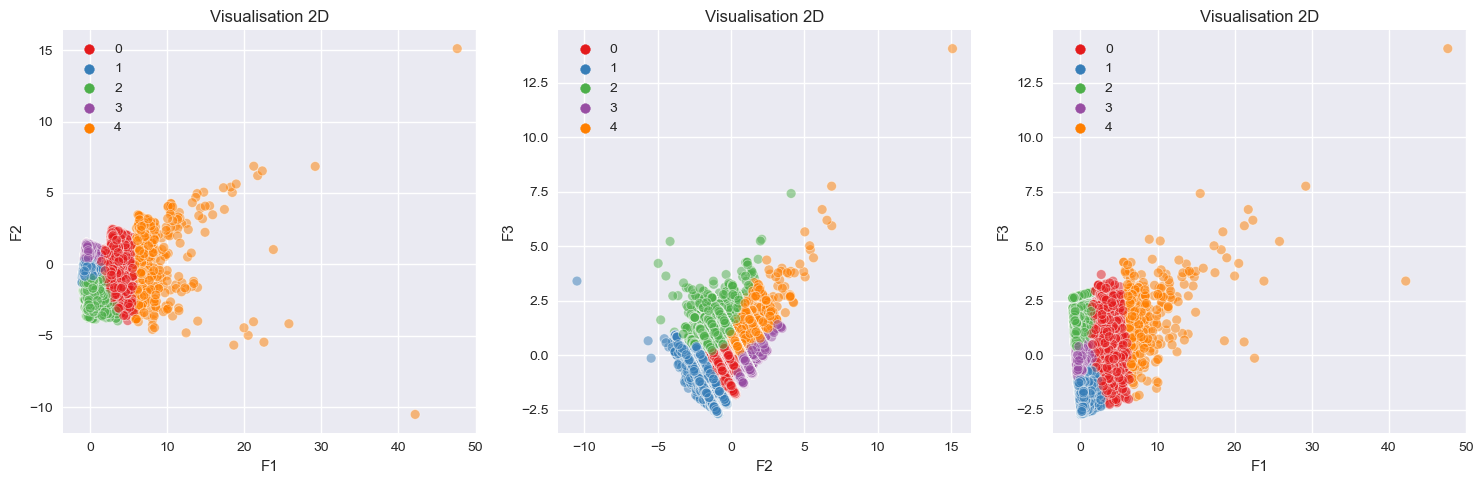

In [ ]:
plot_clusters(
    rfms_scaled_pca,
    [
        ["F1", "F2"],
        ["F2", "F3"],
        ["F1", "F3"],
    ],
    5,
)

#### Visualizing clusters using TSNE

In [ ]:
rfms_scaled["cluster"] = get_kmeans_clusters(rfms_scaled, 5)

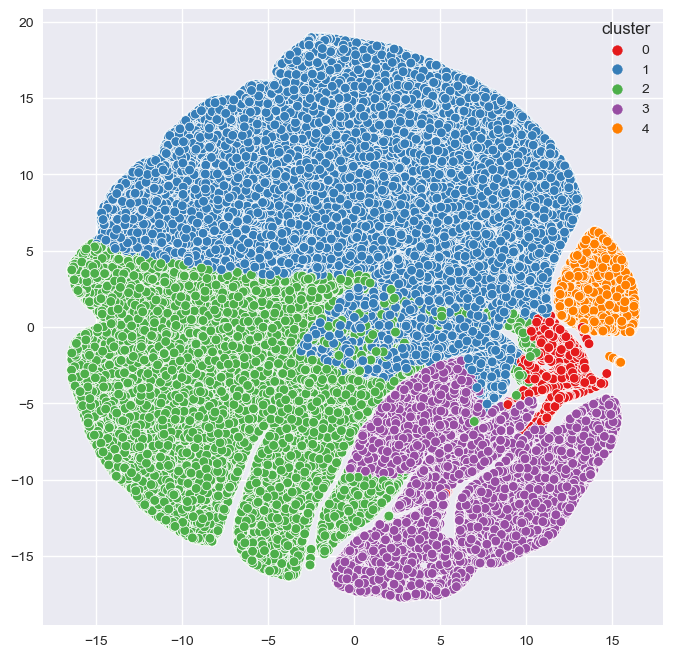

In [ ]:
plot_tsne(rfms_scaled, perplexity=50)

### DBSCAN Algorithm

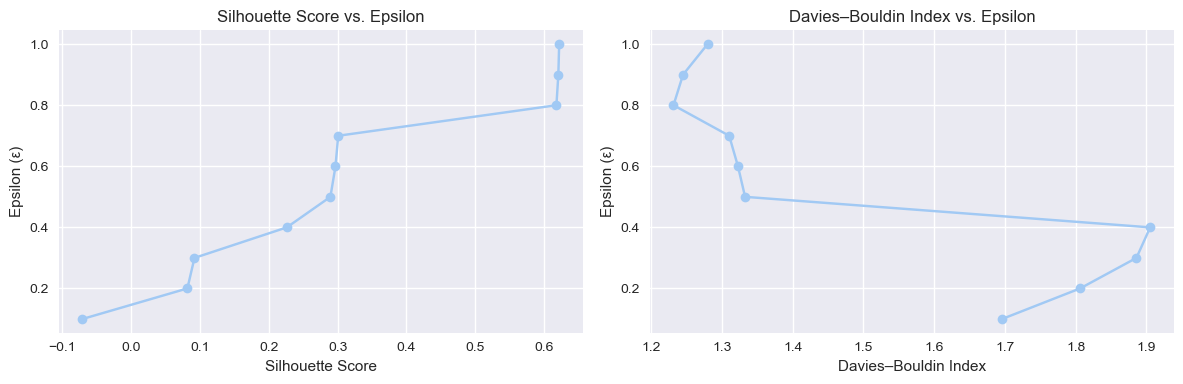

Best Epsilon (Silhouette Score): 1.0
Best Epsilon (Davis-Bouldin Index): 0.8


In [ ]:
find_epsilon(sampled_rfms)

In [ ]:
sampled_rfms["cluster"] = get_dbscan_clusters(sampled_rfms, 1, 150)

[-1  0  1  2  3]


With these hyper-parameters, the dbscan algorithm finds 

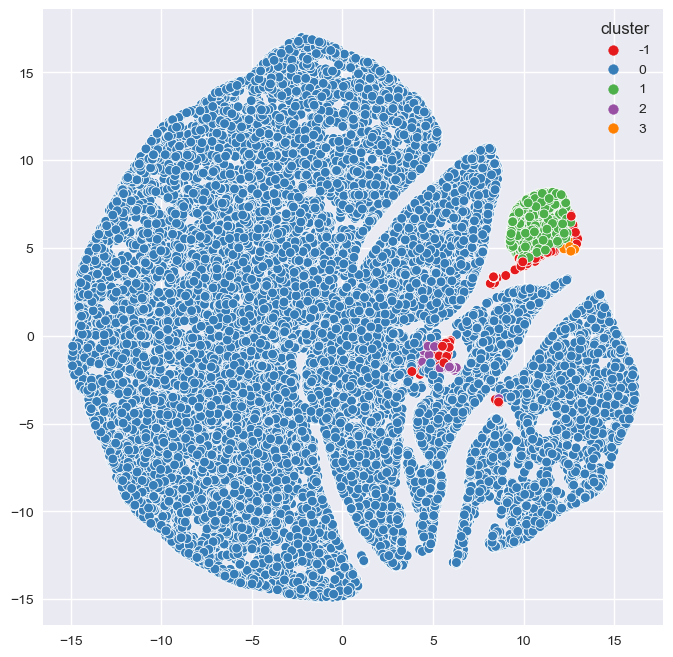

In [ ]:
plot_tsne(sampled_rfms, 30)

The DBSCAN algorithm yields poorer results in terms of cluster definition. We will therefore move forward with the K-Means algorithm

### Interpreting results

In [ ]:
rfms["cluster"] = rfms_scaled["cluster"]

/var/folders/ht/r34_b3vj4p7c88ck54235g_40000gn/T/ipykernel_70793/3971238746.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfms["cluster"] = rfms_scaled["cluster"]


In [ ]:
rfms.describe()

order_frequency   total_price       recency  review_score       cluster
count     93358.000000  93358.000000  93358.000000  93358.000000  93358.000000
mean          1.033420    165.168210    236.941773      4.146061      1.747456
std           0.209097    226.292101    152.591453      1.279175      0.869118
min           1.000000      9.590000      0.000000      1.000000      0.000000
25%           1.000000     63.010000    113.000000      4.000000      1.000000
50%           1.000000    107.780000    218.000000      5.000000      2.000000
75%           1.000000    182.510000    345.000000      5.000000      2.000000
max          15.000000  13664.080000    713.000000      5.000000      4.000000

In [ ]:
rfms_summary = (
    rfms.groupby("cluster")
    .agg(
        order_frequency=("order_frequency", "mean"),
        total_price=("total_price", "mean"),
        recency=("recency", "mean"),
        review_score=("review_score", "mean"),
        cluster_size=("cluster", "count"),
    )
    .round(2)
)

rfms_summary

order_frequency  total_price  recency  review_score  cluster_size
cluster                                                                   
0                   1.02      1240.20   236.71          4.08          2064
1                   1.00       132.65   121.77          4.70         41061
2                   1.00       133.52   393.03          4.63         31393
3                   1.00       150.53   229.34          1.77         16068
4                   2.11       289.62   219.44          4.20          2772

In [63]:
plot_clusters_by_feature(rfms)

NameError: name 'rfms' is not defined

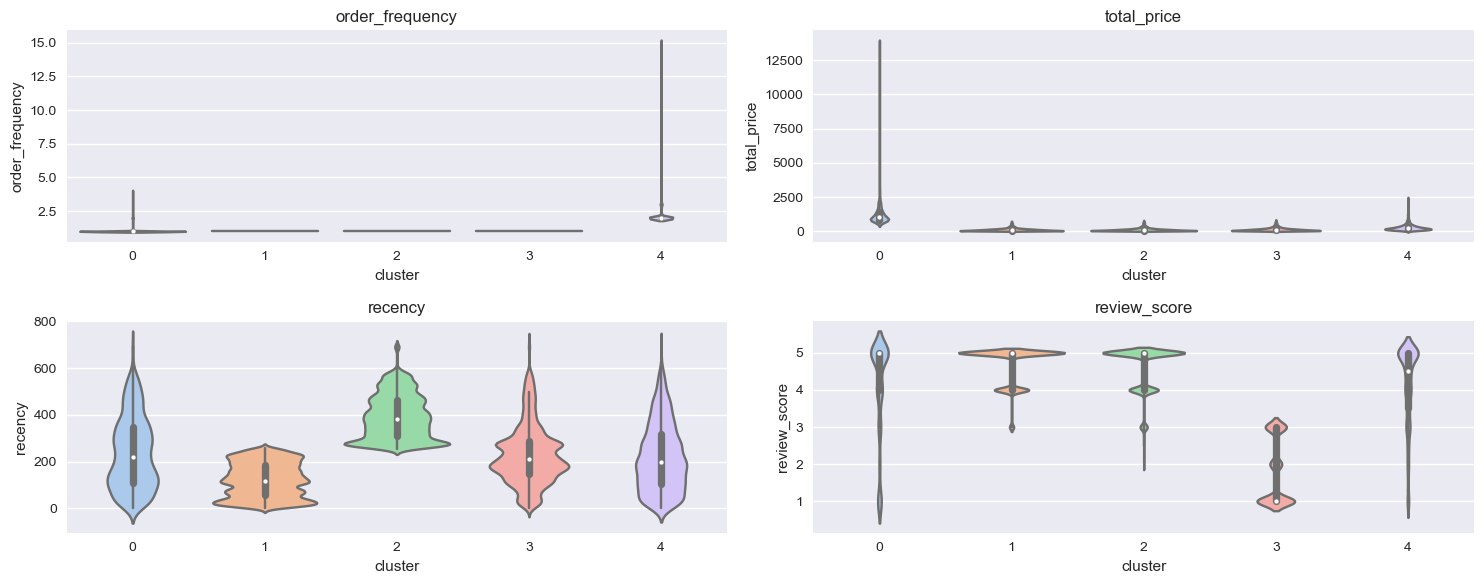

In [ ]:
plot_clusters_by_feature(rfms, "violin")

Cluster 0 : More than 1 order, high spender, ordered within the year and satisfied 

Cluster 1 : Single order, low spender, recent purchase, satisfied  

Cluster 2 : Single order, low spenders, long time ago but satisfied 

Cluster 3 : Single order, low spender, ordered within the year but not satisfied at all 

Cluster 4 : Several orders, high spender, ordered within the year and satisfied at all 

---

In [ ]:
rfms_summary["cluster_name"] = [
    "Engagement Prospects",
    "Newcomers",
    "Impulse buyers",
    "Lost customers",
    "Loyal customers",
]
rfms_summary

order_frequency  total_price  recency  review_score  cluster_size  \
cluster                                                                      
0                   1.02      1240.20   236.71          4.08          2064   
1                   1.00       132.65   121.77          4.70         41061   
2                   1.00       133.52   393.03          4.63         31393   
3                   1.00       150.53   229.34          1.77         16068   
4                   2.11       289.62   219.44          4.20          2772   

                 cluster_name  
cluster                        
0        Engagement Prospects  
1                   Newcomers  
2              Impulse buyers  
3              Lost customers  
4             Loyal customers

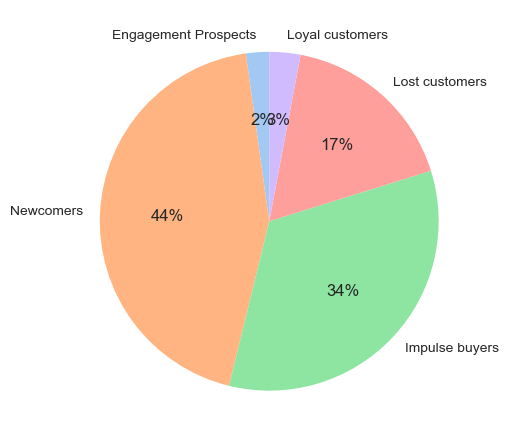

In [ ]:
plt.pie(
    rfms_summary["cluster_size"],
    labels=rfms_summary["cluster_name"],
    autopct="%1.0f%%",
    startangle=90,
)
plt.show()

## RFMS + Content

In order to see if we can further explain each group, we can try adding the category count, to see if the number of items help further differentiate the customers

In [68]:
rfmsc = customers[["order_frequency", "total_price",
                   "recency", "review_score", "mean_item_count"]]

rfmsc_scaled = scale_data(df=rfmsc)

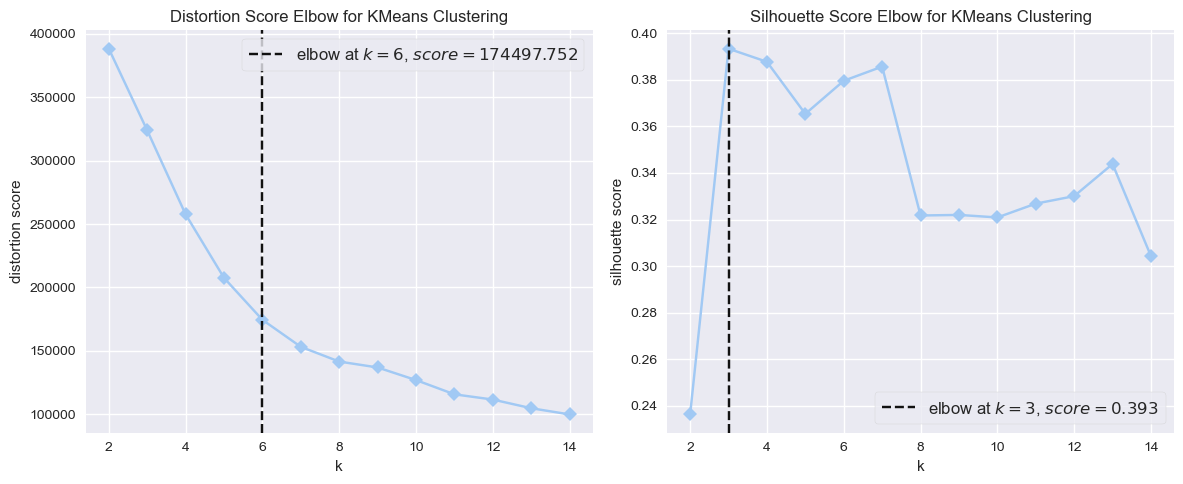

In [33]:
find_k(rfmsc_scaled)

In [69]:
rfmsc_scaled = pd.DataFrame(rfmsc_scaled)

In [70]:
rfmsc_scaled["cluster"] = get_kmeans_clusters(rfmsc_scaled, 6)

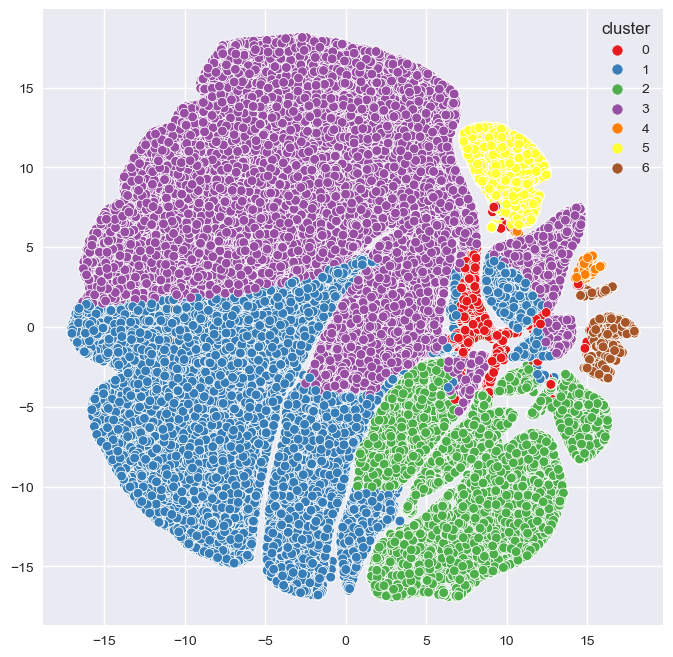

In [41]:
plot_tsne(rfmsc_scaled)

In [71]:
rfmsc["cluster"] = rfmsc_scaled["cluster"]

/var/folders/ht/r34_b3vj4p7c88ck54235g_40000gn/T/ipykernel_96304/4025155926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfmsc["cluster"] = rfmsc_scaled["cluster"]


In [72]:
rfmsc_summary = (
    rfmsc.groupby("cluster")
    .agg(
        order_frequency=("order_frequency", "mean"),
        total_price=("total_price", "mean"),
        recency=("recency", "mean"),
        review_score=("review_score", "mean"),
        mean_item_count=("mean_item_count", "mean"),
        cluster_size=("cluster", "count"),
    )
    .round(2)
)

rfmsc_summary

order_frequency  total_price  recency  review_score  mean_item_count  \
cluster                                                                         
0                   1.01      1278.14   233.82          4.14             1.15   
1                   1.00       132.44   394.14          4.63             1.07   
2                   1.00       145.02   228.37          1.79             1.15   
3                   1.00       131.01   122.98          4.71             1.06   
4                   1.01       340.47   235.10          3.41             3.83   
5                   2.12       287.35   219.53          4.20             1.18   

         cluster_size  
cluster                
0                1816  
1               30676  
2               15484  
3               40649  
4                1978  
5                2755

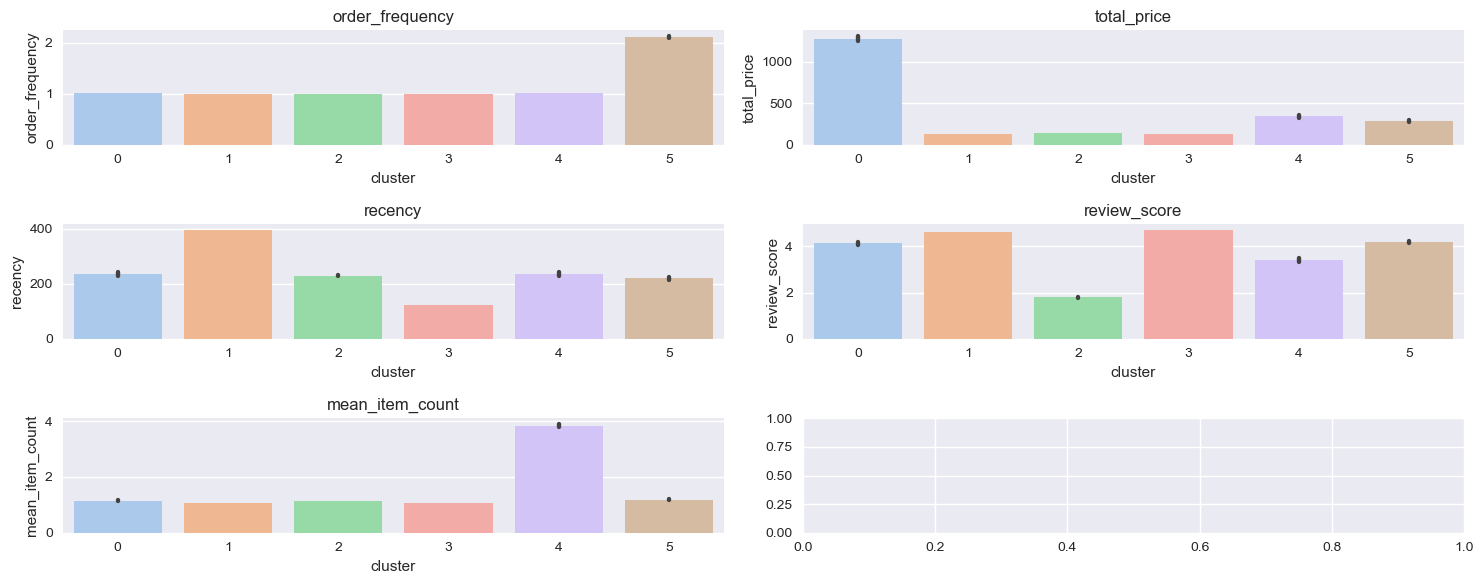

In [73]:
plot_clusters_by_feature(rfmsc)

0 = one time, high spender, semi recent, satisfied, mutliple buys

1 = one time, low spender, old, satisfied, impulse/single need

2 = one time, low spender, semi recent, not satisfied, single need 

3 = one time, low spender, recent, satisfied, single need 

4 = one time, mid spender, semi recent, satisfied, multiple buys 

5 = several purchases, low spender, semi recent, satisfied, more than one need 

---

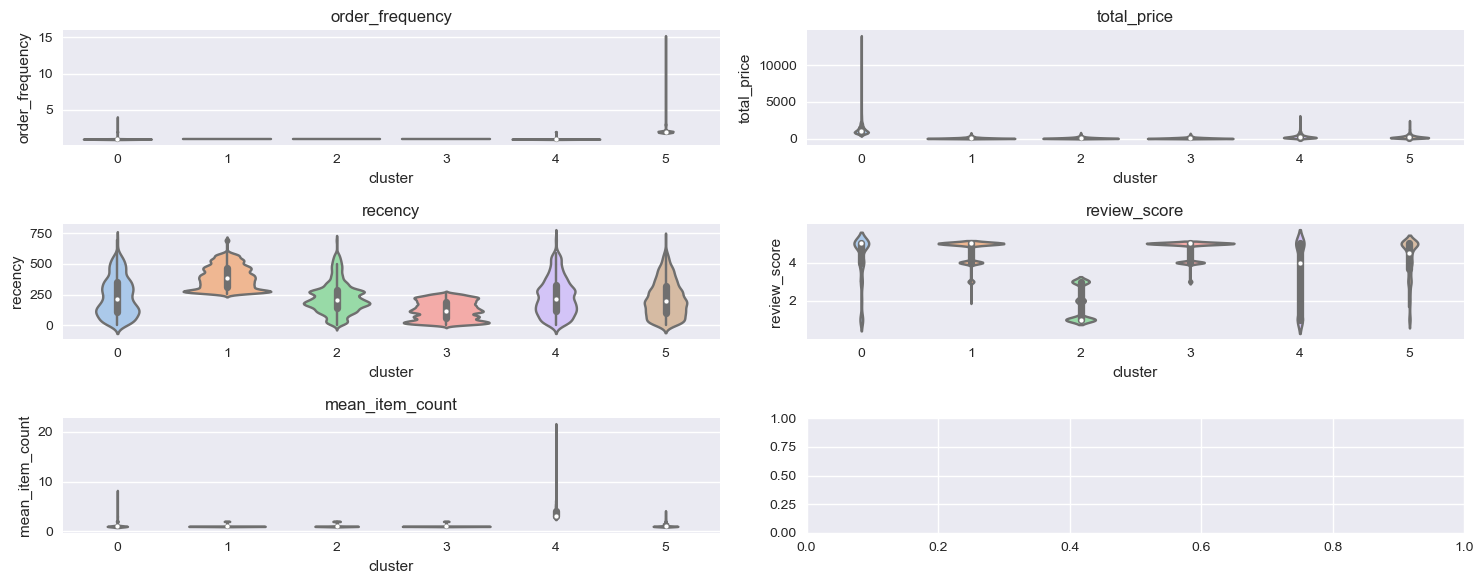

In [74]:
plot_clusters_by_feature(rfmsc, "violin")

This additional feature confirms the groups highlighted by RMFS features. It does not bring any valuable additional information

